# COVID_Patient_Classifier_CV_SMOTE

In [1]:
# Compare Algorithms
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# load dataset
file = '../clean_ml_data_0625.csv'
clean_df = pd.read_csv(file)
clean_df = clean_df.sample(30000)
clean_df.head()

,gender,pneumonia,pregnant,diabetes,copd,asthma,immunosup,hypertension,cardiovascular,obesity,renal_chronic,tobacco,closed_contact,another_complication,death,intubation,ICU,new_age
338331,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,5
693527,1,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,5
154967,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
202777,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,3
124563,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [3]:
# Split target ['death'] and rest of the features
y= clean_df['death']
X = clean_df.drop(columns = ['ICU','intubation','death'])

In [4]:
# check the column names
X.columns

Index(['gender', 'pneumonia', 'pregnant', 'diabetes', 'copd', 'asthma',
       'immunosup', 'hypertension', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'closed_contact', 'another_complication',
       'new_age'],
      dtype='object')

In [5]:
# split the train and test dataset for machine learning analysis
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =42, stratify=y)

In [6]:
from sklearn.preprocessing import StandardScaler
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting standard scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [7]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled_s, y_resampled_s = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(X_train_scaled,y_train)
# Counter(y_resampled_s)

In [8]:
# # Use SMOTEENN resampling method
# from imblearn.combine import SMOTEENN 
# smote_enn = SMOTEENN(random_state=0)
# X_resampled_s, y_resampled_s = smote_enn.fit_resample(X_train_scaled,y_train)
# Counter(y_resampled_s)

In [9]:
# prepare classifier models
models = []
models.append(('LR', LogisticRegression(max_iter=1000,solver='lbfgs', random_state=1)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier(n_estimators=20,learning_rate=1,max_features=None,max_depth=3,random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('RF2', RandomForestClassifier(max_depth=2, random_state=0)))
models.append(('RF4', RandomForestClassifier(max_depth=4, random_state=0)))
models.append(('RF6', RandomForestClassifier(max_depth=6, random_state=0)))

In [10]:
# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_resampled_s, y_resampled_s, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.849171 (0.020857)
SVM: 0.847240 (0.034455)
LDA: 0.831258 (0.027994)
KNN: 0.597778 (0.034693)
CART: 0.862302 (0.047043)
GBC: 0.867168 (0.035180)
NB: 0.810628 (0.011314)
RF2: 0.856954 (0.015295)
RF4: 0.884610 (0.030233)
RF6: 0.878770 (0.016846)


In [11]:
# prepare classifier models
models1 = []
models1.append(('EEC', EasyEnsembleClassifier(random_state=1,n_estimators = 100)))
models1.append(('brfc', BalancedRandomForestClassifier(n_estimators=100, random_state=42)))

In [12]:
# evaluate each model in turn
for name, model in models1:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

EEC: 0.831763 (0.020152)
brfc: 0.873512 (0.016936)


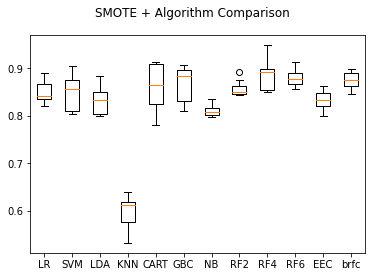

In [14]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('SMOTE + Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()